# Notação

Considerando $I$ uma imagem no domínio $\Omega \subset \mathbb{R}^2$, podemos definir $G$ e $S$ como o conjunto dos píxels na pastílha e $S$ o conjunto de píxels segmentados pela rede, respectivamente. Considere também $g_i^{(c)}$ e $s_i^{(c)}$ o ground-truth e a segmentação, respectivamente, no píxel $i$ com relação à classe $c$. $N$ corresponde ao número total de píxels na image e $C$ o conjunto das classes, $C = \{0, 1\}$ (classificação binária).

O ground-truth e a segmentação no píxel $i$ para uma classe $c$ se definem da seguinte forma:
$$
g_i^{(c)} = \left\{\begin{array}{r, l}
    y_i, &\text{se } c = 1\\
    1 - y_i, &\text{se } c = 0
\end{array}\right.
\quad
\text{e}
\quad
s_i^{(c)} = \left\{\begin{array}{r, l}
    \hat{y}_i,&\text{se } c = 1\\
    1 - \hat{y}_i,&\text{se } c = 0
\end{array}\right.
$$
onde $y_i$ é a segmentação verdadeira (`y_true`)
$$
y_i = \left\{\begin{array}{r, l}
    1, &\text{se } i \in G\\
    0, &\text{se } i \notin G
\end{array}\right.,
$$
e $\hat{y}_i$ (`y_pred`) é uma estimativa da probabilidade do píxel $i$ pertencer ao conjunto $G$ $$\hat{y}_i = P(i|i\in G) \Longrightarrow 0\le \hat{y}_i \le 1.$$
Tal estimativa é fornecida pelo modelo $\hat{Y}: I \to \{\hat{y}_1,\dots , \hat{y}_N\}$.

## Propriedades:
- Interseção: 
$$
|G\cap S| = 
\sum_{c\in C}\sum_{i=1}^N g_i^{(c)}s_i^{(c)} = 
\sum_{i=1}^N g_i^{(1)}s_i^{(1)} + g_i^{(0)}s_i^{(0)} = 
\sum_{i=1}^N y_i \hat{y}_i + (1 - y_i)(1 - \hat{y}_i)
$$

- União: 
$$
\begin{align}
    |G\cup S| 
    &= \sum_{c\in C}\sum_{i=1}^N g_i^{(c)} + s_i^{(c)} - g_i^{(c)}s_i^{(c)}\\
    &= \sum_{c\in C}\sum_{i=1}^N g_i^{(c)} + s_i^{(c)}\left(1 - g_i^{(c)}\right)\\
    &= \sum_{c\in C}\sum_{i=1}^N g_i^{(c)} + s_i^{(c)}g_i^{(1 - c)}\\
    &= \sum_{i=1}^N 
        \left( g_i^{(1)} + s_i^{(1)}g_i^{(0)} \right) + 
        \left( g_i^{(0)} + s_i^{(0)}g_i^{(1)} \right)\\
    &= \sum_{i=1}^N 
        g_i^{(1)}\left(1 + s_i^{(0)}\right) + 
        g_i^{(0)}\left(1 + s_i^{(1)}\right)\\
    &= \sum_{i=1}^N 
        y_i(2 - \hat{y}_i) + 
        (1 - y_i)(1 + \hat{y}_i)\\
\end{align}
$$

- $|G| 
= \sum_{i\in C}\sum_{i=1}^N g_i^{(c)} 
= \sum_{i=1}^N g_i^{(1)} + g_i^{(0)}
= \sum_{i=1}^N y_i + (1 - y_i)
= \sum_{i=1}^N 1
= N$

- $|S| 
= \sum_{i\in C}\sum_{i=1}^N s_i^{(c)} 
= \sum_{i=1}^N s_i^{(1)} + s_i^{(0)}
= \sum_{i=1}^N \hat{y}_i + (1 - \hat{y}_i)
= \sum_{i=1}^N 1
= N$

- |G| = |S| = N

In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Github/PAC/

/content/drive/MyDrive/Github/PAC


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import binary_crossentropy
from src import metrics
from src.data import load_dataset
from src.segmentation import UNet
from src.visualize import set_custom_style
set_custom_style()

# Metrics

## Iou (Intersection over Union)

$$
\text{IoU}(G, S) = \frac{|G \cap S|}{|G \cup S|} 
\approx 
\frac{
    \sum_{i=1}^N y_i \hat{y}_i + (1 - y_i)(1 - \hat{y}_i)
}{
    \sum_{i=1}^N 
        y_i(2 - \hat{y}_i) + 
        (1 - y_i)(1 + \hat{y}_i)
}
$$

## DSC (Dice Similarity Coefficient)

$$
\text{DSC}(G, S) = \frac{2|G \cap S|}{|G| + |S|}
\approx
    \frac{
        2\sum_{i=1}^N y_i \hat{y}_i + (1 - y_i)(1 - \hat{y}_i)
    }{
        N + N
    }
= \frac{1}{N}\sum_{i=1}^N y_i \hat{y}_i + (1 - y_i)(1 - \hat{y}_i)
$$

In [ ]:
@tf.function
def IoU(y_true, y_pred):
    intersection = tf.math.reduce_sum(y_true*y_pred + (1 - y_true)*(1 - y_pred), axis=(1, 2, 3))
    union = tf.math.reduce_sum(y_true*(2 - y_pred) + (1 - y_true)*(1 + y_pred), axis=(1, 2, 3))
    return intersection/union

@tf.function
def DSC(y_true, y_pred):
    return tf.math.reduce_mean(y_true*y_pred + (1 - y_true)*(1 - y_pred), axis=(1, 2, 3))

In [ ]:
%%time
dataset = (x_train, y_train), (x_test, y_test) = load_dataset(augmentation=True, grayscale=True, as_tensor=True, norm=True)

CPU times: user 2.09 s, sys: 476 ms, total: 2.57 s
Wall time: 5.36 s


# Dice Loss

De acordo com [Loss odyssey](https://doi.org/10.1016/j.media.2021.102035), a função de perda Dice $L_{Dice}$ pode ser definida como
$$
L_{Dice} = 1 - \dfrac{2\sum_{c\,\in\,C}\sum_{i=1}^{N}g_i^{(c)} s_i^{(c)}}{\sum_{c\,\in\,C}\sum_{i=1}^{N}g_i^{(c)} + \sum_{c\,\in\,C}\sum_{i=1}^{N}s_i^{(c)}}.
$$

Simplificando, temos
$$
\boxed{
L_{Dice} = 1 - \text{DSC}(G, S).
}
$$

In [ ]:
class Dice(Loss):
    def __init__(self):
        super().__init__()
    
    def call(self, y_true, y_pred):
        return 1 - DSC(y_true, y_pred)

In [ ]:
unet = UNet('unet_dice_test', dataset).load(compile=False) #.build((16, 32, 64))
unet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=Dice(),
    metrics=[DSC, IoU, binary_crossentropy, metrics.area_mape]
)

In [ ]:
unet.summary()

Model: "unet_dice_test"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                    

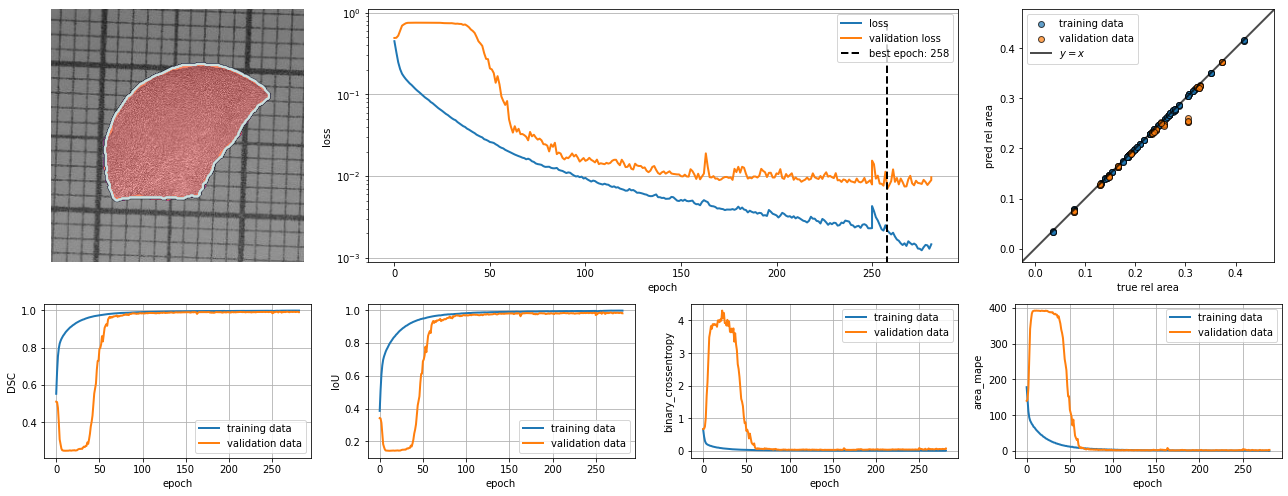

,epoch,DSC,IoU,area_mape,binary_crossentropy,loss,val_DSC,val_IoU,val_area_mape,val_binary_crossentropy,val_loss
259,258,0.997838,0.995686,0.410283,0.006128,0.002162,0.992986,0.986099,1.153924,0.040083,0.007014
268,267,0.998493,0.996991,0.355959,0.004517,0.001507,0.992537,0.985238,1.255880,0.047375,0.007463
269,268,0.998602,0.997208,0.290152,0.004078,0.001398,0.992507,0.985193,1.232979,0.047622,0.007493
257,256,0.997847,0.995703,0.490249,0.005628,0.002153,0.992356,0.984905,1.311688,0.041349,0.007644
273,272,0.998504,0.997014,0.309634,0.004816,0.001496,0.992278,0.984753,1.341684,0.050243,0.007722


6/6 [==============================] - 113s 20s/step - loss: 0.0015 - DSC: 0.9985 - IoU: 0.9971 - binary_crossentropy: 0.0054 - area_mape: 0.3552 - val_loss: 0.0097 - val_DSC: 0.9903 - val_IoU: 0.9811 - val_binary_crossentropy: 0.0713 - val_area_mape: 2.5843


In [ ]:
history = unet.fit(1, unet.x_train.shape[0]//6, plot=True, period=10, ranking=5)

# TopK Loss

De forma generalizada, a função de perda TopK é definida como
$$
L_{TopK} = -\frac{1}{N} \sum_{c\in C} \sum_{i \in \mathbf{k}} g_i^{(c)} \ln s_i^{(c)},
$$
onde $\mathbf{K}$ representa os $k\%$ piores píxels. Assim, para classificação binária, a função se reduz a
$$
\begin{align}
    L_{TopK} 
    = -\frac{1}{N} \sum_{i\in\mathbf{k}} 
        g_i^{(1)} \ln s_i^{(1)} +
        g_i^{(0)} \ln s_i^{(0)}
    = -\frac{1}{N} \sum_{i\in\mathbf{k}} 
        y_i \ln \hat{y}_i + 
        (1 - y_i) \ln (1 - \hat{y}_i)
\end{align}
$$


In [ ]:
class TopK(Loss):
    def __init__(self, k, image_shape):
        super().__init__()
        assert 0 <= k <= 1
        self.N = tf.cast(tf.reduce_prod(image_shape), tf.float32)
        self.k = tf.cast(self.N*k, tf.int32) # k's threshold
    
    @tf.function
    def top_k(self, x):
        return tf.reduce_sum(tf.math.top_k(tf.reshape(x, [-1]), k=self.k, sorted=False).values)/self.N
    
    @tf.function
    def call(self, y_true, y_pred):
        loss = - y_true*tf.math.log(y_pred) - (1 - y_true)*tf.math.log(1 - y_pred)
        return tf.map_fn(self.top_k, loss, fn_output_signature=tf.float32)

In [ ]:
unet = UNet('unet_topk-10_test', dataset).load(compile=False) #.build((16, 32, 64))
unet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=TopK(k=0.1, image_shape=x_train.shape[1:-1]),
    metrics=[DSC, IoU, binary_crossentropy, metrics.area_mape]
)

In [ ]:
unet.summary()

Model: "unet_topk-10_test"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_66 (Conv2D)             (None, 256, 256, 16  160         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_60 (BatchN  (None, 256, 256, 16  64         ['conv2d_66[0][0]']              
 ormalization)                  )                                                 

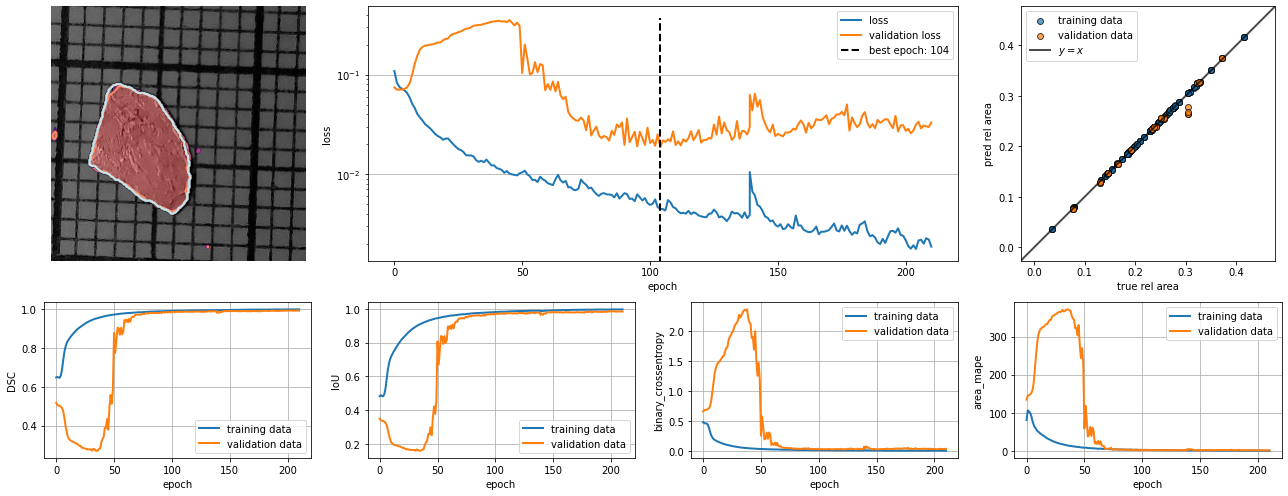

,epoch,DSC,IoU,area_mape,binary_crossentropy,loss,val_DSC,val_IoU,val_area_mape,val_binary_crossentropy,val_loss
104,104,0.991144,0.982443,2.400367,0.010095,0.004487,0.985996,0.972415,1.997458,0.024905,0.018579
95,95,0.989149,0.978534,2.911615,0.013004,0.006257,0.984328,0.969184,3.146708,0.026436,0.018961
102,102,0.990428,0.981040,2.630729,0.011435,0.005556,0.985602,0.971654,2.296359,0.025714,0.019273
112,112,0.992270,0.984658,1.836885,0.008810,0.004030,0.987176,0.974721,1.829901,0.024668,0.019414
110,110,0.991854,0.983840,2.026054,0.009484,0.004516,0.986885,0.974172,1.989788,0.025021,0.019590


6/6 [==============================] - 118s 21s/step - loss: 0.0019 - DSC: 0.9983 - IoU: 0.9965 - binary_crossentropy: 0.0024 - area_mape: 0.2559 - val_loss: 0.0331 - val_DSC: 0.9916 - val_IoU: 0.9835 - val_binary_crossentropy: 0.0337 - val_area_mape: 1.3816
Epoch 212/639
3/6 [==============>...............] - ETA: 37s - loss: 0.0020 - DSC: 0.9982 - IoU: 0.9964 - binary_crossentropy: 0.0025 - area_mape: 0.3266

In [ ]:
history = unet.fit(500, unet.x_train.shape[0]//6, plot=True, period=10, ranking=5)

# Dice + Topk

In [ ]:
class DiceTopK(Dice, TopK):
    def __init__(self, *args, **kwargs):
        super(Dice, self).__init__(*args, **kwargs)
        super(TopK, self).__init__()
    
    def call(self, y_true, y_pred):
        return Dice.call(self, y_true, y_pred) + TopK.call(self, y_true, y_pred)

In [ ]:
unet = UNet('unet_dice-topk-10_test', dataset).build((16, 32, 64))
unet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=DiceTopK(k=0.1, image_shape=x_train.shape[1:-1]),
    metrics=[DSC, IoU, binary_crossentropy, metrics.area_mape]
)

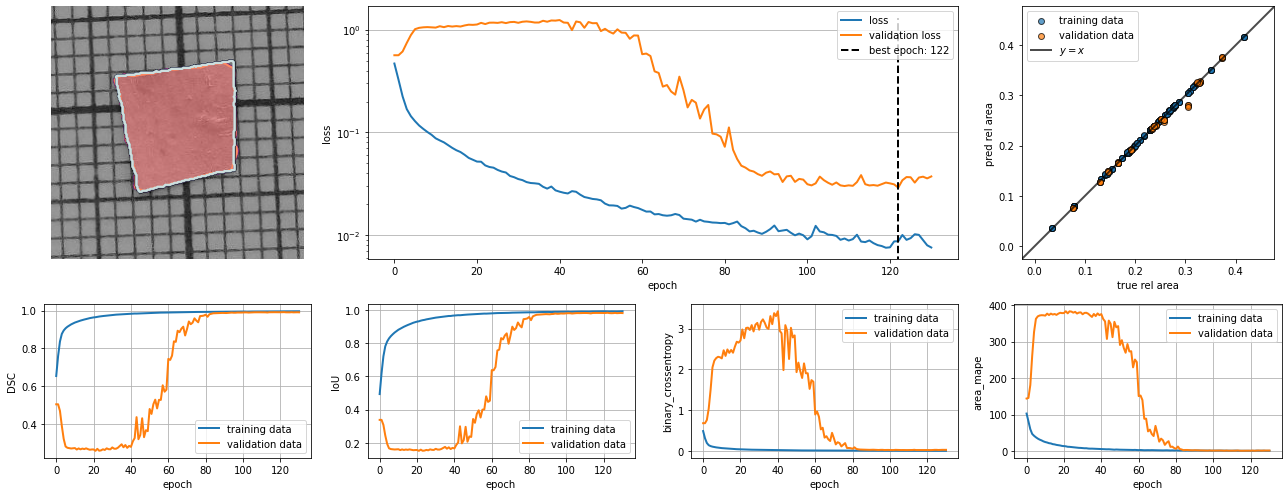

,epoch,DSC,IoU,area_mape,binary_crossentropy,loss,val_DSC,val_IoU,val_area_mape,val_binary_crossentropy,val_loss
122,122,0.995827,0.991690,0.707470,0.006045,0.008722,0.991656,0.983467,0.887771,0.022328,0.029023
109,109,0.995299,0.990642,1.059592,0.006427,0.009274,0.990915,0.982013,1.146327,0.022923,0.030077
111,111,0.995406,0.990855,1.160706,0.006323,0.009140,0.990910,0.982004,1.257246,0.023046,0.030222
117,117,0.995883,0.991800,0.901774,0.005492,0.007999,0.991267,0.982706,1.042730,0.023284,0.030307
115,115,0.995575,0.991191,1.061733,0.006136,0.008880,0.991239,0.982649,0.849671,0.023457,0.030469


6/6 [==============================] - 188s 34s/step - loss: 0.0076 - DSC: 0.9963 - IoU: 0.9925 - binary_crossentropy: 0.0051 - area_mape: 0.7241 - val_loss: 0.0373 - val_DSC: 0.9906 - val_IoU: 0.9816 - val_binary_crossentropy: 0.0292 - val_area_mape: 1.4469
Epoch 132/500
6/6 [==============================] - 137s 23s/step - loss: 0.0078 - DSC: 0.9962 - IoU: 0.9924 - binary_crossentropy: 0.0053 - area_mape: 0.8010 - val_loss: 0.0347 - val_DSC: 0.9910 - val_IoU: 0.9823 - val_binary_crossentropy: 0.0271 - val_area_mape: 1.2268
Epoch 133/500
6/6 [==============================] - 133s 23s/step - loss: 0.0071 - DSC: 0.9964 - IoU: 0.9928 - binary_crossentropy: 0.0048 - area_mape: 0.7814 - val_loss: 0.0338 - val_DSC: 0.9910 - val_IoU: 0.9823 - val_binary_crossentropy: 0.0261 - val_area_mape: 1.1567
Epoch 134/500
6/6 [==============================] - 145s 25s/step - loss: 0.0072 - DSC: 0.9964 - IoU: 0.9929 - binary_crossentropy: 0.0049 - area_mape: 0.7382 - val_loss: 0.0345 - val_DSC: 0.991

In [ ]:
history = unet.fit(500, unet.x_train.shape[0]//6, plot=True, period=10, ranking=5)

# Boundary-based metric

In [ ]:
from src.data import load_all
from scipy.interpolate import splprep, splev

In [ ]:
images, masks = load_all()
images.shape, masks.shape

(TensorShape([63, 256, 256, 1]), TensorShape([63, 256, 256, 1]))

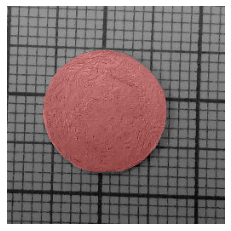

In [ ]:
i = np.random.randint(images.shape[0])
vs.plot_label(images[i], masks[i])

In [ ]:
def get_boundary(masks):
    pad = tf.pad(masks, ((0, 0), (0, 1), (0, 1), (0, 0)))
    dy = masks - pad[:, 1:, :-1]
    dx = masks - pad[:, :-1, 1:]
    return tf.reduce_any(tf.cast(tf.stack((dy, dx)), tf.bool), axis=0)    

edges = get_boundary(masks)
del_G = edges[i, ..., 0].numpy()

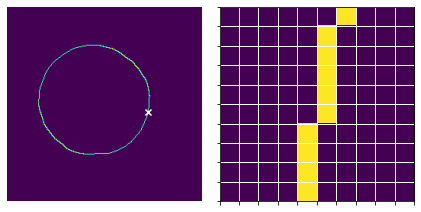

In [ ]:
fig = plt.figure(figsize=(6, 3))

X, Y = np.meshgrid(np.arange(edges.shape[2]), np.arange(edges.shape[1]))
j = np.random.randint(np.sum(del_G))
x, y = X[del_G][j], Y[del_G][j]

fig.add_subplot(121)
vs.plot_image(del_G)
plt.scatter(x, y, marker='x', c='w')

ax = fig.add_subplot(122)
ax.imshow(del_G[y-5:y+5, x-5:x+5])
ax.set_xticks(np.arange(-0.5, 10), [])
ax.set_yticks(np.arange(-0.5, 10), [])
ax.grid(True, color='w', linestyle='-', linewidth=1)

fig.tight_layout()

In [ ]:
def random_segmentation(shape, n, k=500):
    r_max = np.min(shape)/2
    d_theta = 2*np.pi/n
    theta = np.arange(0, 2*np.pi, d_theta)
    rho = np.random.randint(0, r_max, n)
    x = rho*np.cos(theta) + shape[1]/2
    y = rho*np.sin(theta) + shape[0]/2
    tck, u = splprep((np.r_[x, x[0]], np.r_[y, y[0]]), s=0, per=True)
    xi, yi = splev(np.linspace(0, 1, k), tck)
    X, Y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    Z = np.zeros(shape)
    for xn, yn in zip(xi, yi):
        Z[(X == int(xn)) & (Y == int(yn))] = 1
    return Z.astype(bool)

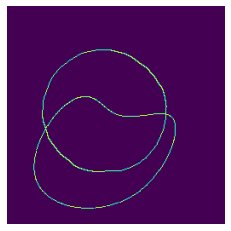

In [ ]:
fig, ax = plt.subplots()
del_S = random_segmentation(del_G.shape, 5)
vs.plot_image(del_G | del_S)

plt.show()